In [1]:
import numpy as np
import gym
import random

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [50]:
from gym.envs.box2d.lunar_lander import LunarLander

class LunarLanderModifiedReward(LunarLander):
    def step(self, action: int):
        new_state, reward, done, info = super().step(action)
        if np.abs(new_state[0]) >= 1:
            reward -= 1000
        if reward == 100:
            reward *= 10
        if reward == -100:
            reward *= 10

        return new_state, reward-10, done, info


In [51]:
# env = LunarLanderModifiedReward()

In [4]:
env = gym.make('LunarLander-v2' )
# env = gym.wrappers.Monitor(env, 'recordings1')

In [5]:
def build_model(states, actions):
    inputs = layers.Input(shape=(1, states))
    x = layers.Dense(256, activation="relu") (inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu") (x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu") (x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu") (x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(actions, activation="linear")(x)
    return Model(inputs, outputs, name="LunarLander")

In [6]:
model = build_model(8,4)

In [7]:
model.summary()

Model: "LunarLander"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 dense (Dense)               (None, 1, 256)            2304      
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 128)            32896     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_2 (Dense)             (None, 1, 128)            16512     
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            

In [8]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, policy=policy, memory=memory, nb_actions=actions, nb_steps_warmup=1000, target_model_update=0.1, gamma=0.99)
    return dqn

In [9]:
dqn = build_agent(model, 4)
dqn.compile(Adam(learning_rate=1e-3), metrics=["mae"])

In [11]:
from callbacks import TrainEpisodeLogger
callbacks = [TrainEpisodeLogger("./model/", episodes_for_averaging=20)]

In [17]:
history = dqn.fit(env,nb_steps=1000000,visualize=False,verbose = 0, callbacks=callbacks, nb_max_episode_steps=1000)

Training for 1000000 steps ...
Number of episodes for accumulate = 20
 128873/1000000: episode: 1, duration: 0.997s, episode steps: 175, steps per second: 176, episode reward: 1.268, mean reward: 0.007 [-100.000, 17.991], mean action: 1.851 [0.000, 3.000], loss: --, mae: --, mean_q: --
The reward is lower than the best one, checkpoint weights not updated
 128999/1000000: episode: 2, duration: 0.639s, episode steps: 126, steps per second: 197, episode reward: -1.015, mean reward: -0.008 [-100.000, 18.545], mean action: 1.849 [0.000, 3.000], loss: --, mae: --, mean_q: --
The reward is lower than the best one, checkpoint weights not updated
 129999/1000000: episode: 3, duration: 12.569s, episode steps: 1000, steps per second: 80, episode reward: 137.911, mean reward: 0.138 [-18.920, 12.880], mean action: 1.332 [0.000, 3.000], loss: 11.605567, mae: 34.588356, mean_q: 46.187516
The reward is lower than the best one, checkpoint weights not updated
 130284/1000000: episode: 4, duration: 7.733

In [18]:
_ = dqn.test(env, nb_episodes=4, visualize=True)

Testing for 4 episodes ...
Episode 1: reward: -243.006, steps: 383
Episode 2: reward: -80.729, steps: 1000
Episode 3: reward: -69.349, steps: 1000


KeyboardInterrupt: 

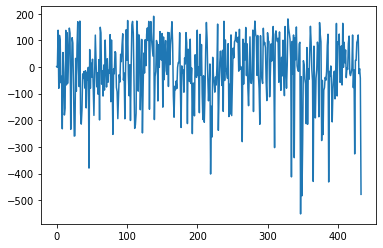

In [19]:
import  matplotlib.pyplot as plt
plt.plot(history.history["episode_reward"])
plt.show()

In [15]:
model1 = build_model(8,4)
dqn1 = build_agent(model1, 4)
dqn1.compile(Adam(learning_rate=1e-3), metrics=["mae"])
dqn1.load_weights("model/checkpoint_reward_216.07929728701765.h5f")

In [16]:
_ = dqn1.test(env, nb_episodes=4, visualize=True)

Testing for 4 episodes ...


C:\Users\leff0\anaconda3\envs\ml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode 1: reward: -196.370, steps: 1000
Episode 2: reward: -174.996, steps: 1000
Episode 3: reward: -170.461, steps: 1000


KeyboardInterrupt: 